# Table of Contents

- [Data Preprocessing](#data-preprocessing)
- [Data and Insights Analysis](#data-and-insights-analysis)
    1. [Brand Overview Analysis](#brand-overview-analysis)
    2. [Impact of Time Analysis: Days Since Release vs. Average Profit](#time-analysis)
    3. [Product Concentration and Distribution](#product-concentration)
    4. [Rarity as a Driver of Profitability](#rarity)
    5. [Timing of Sales Post-Release](#timing-sales)
    6. [Linear Regression Model to see the most influential factors](#linear-regression)

In [112]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import statsmodels.api as sm

**Data Description:**  
This dataset consists of sales data from StockX, a sneaker resale platform. It contains sales for Off-White x Nike and Yeezy 350 sneakers between 2017-09-01 (the month that Off-White first debuted “The Ten” collection) and 2019-02-13. The sample consists of U.S. sales only.

In [113]:
# load the dataset
df = pd.read_csv('StockX_data.csv', header=0, names=['order_date', 'brand', 'sneaker_name', 'sale_price', 'retail_price', 'release_date', 'shoe_size', 'buyer_region'])

# output the first 5 rows
df.head()

,order_date,brand,sneaker_name,sale_price,retail_price,release_date,shoe_size,buyer_region
0,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,"$1,097",$220,9/24/16,11.0,California
1,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,$685,$220,11/23/16,11.0,California
2,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,$690,$220,11/23/16,11.0,California
3,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,"$1,075",$220,11/23/16,11.5,Kentucky
4,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$828,$220,2/11/17,11.0,Rhode Island



# <a id="data-preprocessing"><a/> Data Preprocessing


Check the data types and non-null counts of the columns in the DataFrame using `df.info()`

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_date    99956 non-null  object 
 1   brand         99956 non-null  object 
 2   sneaker_name  99956 non-null  object 
 3   sale_price    99956 non-null  object 
 4   retail_price  99956 non-null  object 
 5   release_date  99956 non-null  object 
 6   shoe_size     99956 non-null  float64
 7   buyer_region  99956 non-null  object 
dtypes: float64(1), object(7)
memory usage: 6.1+ MB


In [115]:
# Change order date and release date from type object to datetime
df['order_date'] = pd.to_datetime(df['order_date'], format='%m/%d/%y')
df['release_date'] = pd.to_datetime(df['release_date'], format='%m/%d/%y')

In [116]:
# Remove unwanted characters and change the data type of the sale_price and retail_price columns
df['sale_price'] = df['sale_price'].str.replace(r'[$,]', '', regex=True).astype(float)
df['retail_price'] = df['retail_price'].str.replace(r'[$,]', '', regex=True).astype(float)

Analyse the brand distribution in the data

In [117]:
df['brand'].value_counts()

brand
 Yeezy       72162
Off-White    27794
Name: count, dtype: int64

It appears that the "Yeezy" brand has unwanted whitespace in the name, so I will clean this up as well as the other categorical fields in case

In [118]:
df['brand'] = df['brand'].str.strip()
df['sneaker_name'] = df['sneaker_name'].str.strip()
df['buyer_region'] = df['buyer_region'].str.strip()

Create a new field which records the number of days after the release date of the shoe that the order ocurred

In [119]:
df["days_since_release"] = (df["order_date"] - df["release_date"]).dt.days

Create two new fields used to display the profit or loss made from resale, as total dollar value and as a premium percentage over retail price

In [120]:
df["resale_profit_loss"] = df["sale_price"] - df["retail_price"]
df["resale_profit_loss_pct"] = round((df["resale_profit_loss"] / df["retail_price"]) * 100, 2)

In [121]:
# Create field to map the brand to parent company - Nike or Adidas
brand_parent_mapping = {'Yeezy': 'Adidas',
                        'Off-White': 'Nike'}

df['parent_company'] = df['brand'].map(brand_parent_mapping)

Get the summary statistics for each column using `df.describe()`

In [122]:
df.describe()

,order_date,sale_price,retail_price,release_date,shoe_size,days_since_release,resale_profit_loss,resale_profit_loss_pct
count,99956,99956.000000,99956.00000,99956,99956.000000,99956.000000,99956.000000,99956.000000
mean,2018-08-12 21:24:50.623874560,446.634719,208.61359,2018-02-10 04:24:17.057105408,9.344181,183.708722,238.021129,124.824503
min,2017-09-01 00:00:00,186.000000,130.00000,2015-06-27 00:00:00,3.500000,-69.000000,-34.000000,-15.450000
25%,2018-05-02 00:00:00,275.000000,220.00000,2017-09-09 00:00:00,8.000000,10.000000,58.000000,26.360000
50%,2018-09-24 00:00:00,370.000000,220.00000,2017-12-16 00:00:00,9.500000,56.000000,154.000000,70.450000
75%,2018-12-15 00:00:00,540.000000,220.00000,2018-08-03 00:00:00,11.000000,345.000000,342.000000,161.360000
max,2019-02-13 00:00:00,4050.000000,250.00000,2019-02-07 00:00:00,17.000000,1321.000000,3860.000000,2031.580000
std,NaN,255.982969,25.20001,NaN,2.329588,232.354142,266.133179,150.856279


Identify if there were orders placed before release as pre-orders

In [123]:
# check the number of orders placed before release date
df.loc[(df['order_date'] < df['release_date'])].shape

(5601, 12)

Create a new field, `pre_order`, as a binary field marking whether a sale was pre ordered or not

In [124]:
df["pre_order"] = np.where(df["days_since_release"] < 0, 1, 0)


# <a id="data-and-insights-analysis"><a/> Data and Insights Analysis



## <a id="brand-overview-analysis"><a/> Brand Overview Analysis


**Aggregate the data by parent company to get aggregated statistics**

In [125]:
brand_overview = df.groupby(['parent_company']).agg(
    total_orders = ('order_date', 'count'),
    total_resale_revenue = ('sale_price', 'sum'),
    avg_resale_price = ('sale_price', 'mean'),
    total_resale_profit = ('resale_profit_loss', 'sum'),
    avg_resale_profit = ('resale_profit_loss', 'mean'),
    avg_resale_profit_pct = ('resale_profit_loss_pct', 'mean')
    )

brand_overview

,total_orders,total_resale_revenue,avg_resale_price,total_resale_profit,avg_resale_profit,avg_resale_profit_pct
parent_company,,,,,,
Adidas,72162,25980669.0,360.032552,10114129.0,140.158657,63.953379
Nike,27794,18663151.0,671.481291,13677511.0,492.103008,282.865162


This analysis of Nike Off-White and Adidas Yeezy collaboration sales outlines two very different strategies within the sneaker resale market.

**Adidas Yeezy**  
- 72,162 total orders
- $25.9 million in resale revenue
- \$360 average resale price
- \$140 average resale profit
- 64% resale premium  

**Nike Off-White**  
- 27,794 total orders
- $18.7 million in resale revenue
- \$671 average resale price
- \$492 average resale profit
- 283% resale premium

**Key Insights**  

1. **Sales Volume**
    - On the surface, Adidas appears to dominate the market through scale. The sheer volume of sales translates into a substantial revenue contribution.

2. **Profitability**  
    - However, Nike generates higher total profits vs. Adidas, despite 61% less total sales volume. This indicates a more premium positioning.
    - Each pair of Off-White sneakers generates nearly twice the revenue of a Yeezy, despite selling in less than half the volume.
    - This suggests that consumers are less price-sensitive with Nike and willing to pay 3–4x retail. These high margins indicate strong brand equity and consumer willingness to pay premiums, which translates into sustainable pricing power.

**Investment Implications**

These results outline the contrasting performance of the two strategies:  
- Adidas Yeezy is positioned as a mass-premium product, using volume and consumer accessibility to capture market share.
- Whereas Nike Off-White uses a premium driven strategy, where exclusivity increases consumers willingness to pay far above retail.

Adidas’s strategy demonstrates the potential of scale to generate steady, recurring revenue streams at thinner margins. Nike illustrates the profitability of exclusivity, where fewer units sold can still translate into outsized financial returns.

This analysis suggests that the most attractive opportunities in the sneaker industry may lie with brands that can successfully balance these two dynamics. Too much emphasis on scale risks brand dilution and thinner margins, while an overreliance on scarcity limits total addressable market. Companies that balances the two most effectively are likely to deliver the strongest long-term growth and investor returns.


## <a id="time-analysis"><a/> Impact of Time Analysis: Days Since Release vs. Average Profit


In [126]:
# find aggregations metrics for each day since release value
days_since_release_metrics = df.groupby(['parent_company', 'days_since_release'], as_index=False).agg(
    total_orders = ('order_date', 'count'),
    total_revenue = ('sale_price', 'sum'),
    avg_profit = ('resale_profit_loss', 'mean'),
    avg_profit_pct = ('resale_profit_loss_pct', 'mean')
)

In [127]:
# create two dataframes for each brand by filtering
nike_days_since = days_since_release_metrics.loc[(days_since_release_metrics['parent_company'] == 'Nike')]
adidas_days_since = days_since_release_metrics.loc[(days_since_release_metrics['parent_company'] == 'Adidas')]

**Calculate correlations between days since release and average profit percentage for each brand**

*Nike* correlation

In [128]:
nike_corr = nike_days_since[['days_since_release', 'avg_profit_pct']].corr()
nike_corr

,days_since_release,avg_profit_pct
days_since_release,1.000000,0.677905
avg_profit_pct,0.677905,1.000000


*Adidas* correlation

In [129]:
adidas_corr = adidas_days_since[['days_since_release', 'avg_profit_pct']].corr()
adidas_corr

,days_since_release,avg_profit_pct
days_since_release,1.000000,0.736259
avg_profit_pct,0.736259,1.000000


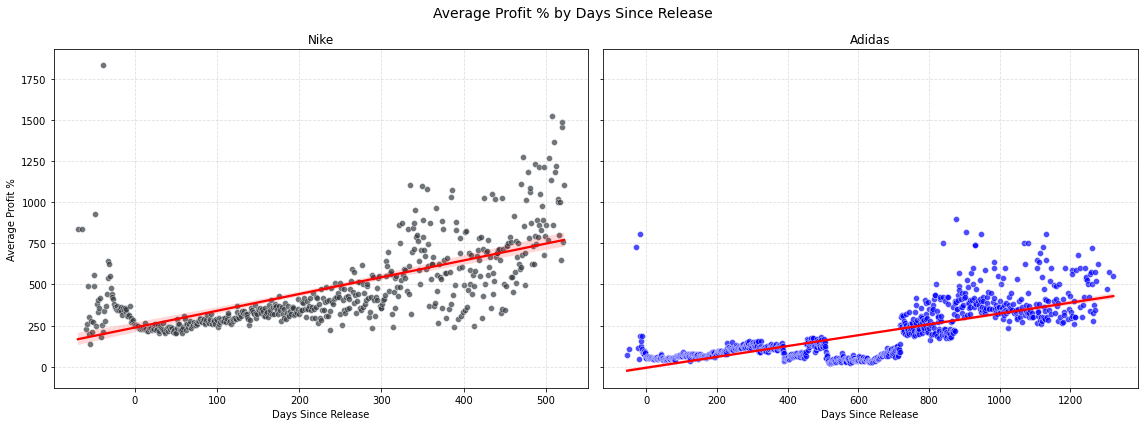

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True) # 1 row, 2 columns

# Nike plots
# create scatterplot
sns.scatterplot(data=nike_days_since,
                x='days_since_release',
                y='avg_profit_pct',
                color='#343a40',
                alpha=0.7,
                ax=axes[0])
# Add a trendline
sns.regplot(data=nike_days_since,
            x='days_since_release',
            y='avg_profit_pct',
            scatter=False,
            color='red',
            ax=axes[0])
axes[0].set_title('Nike')
axes[0].set_xlabel('Days Since Release')
axes[0].set_ylabel('Average Profit %')
axes[0].grid(True, linestyle='--', alpha=0.4)


# Adidas plots
# create scatterplot
sns.scatterplot(data=adidas_days_since,
                x='days_since_release',
                y='avg_profit_pct',
                color='blue',
                alpha=0.7,
                ax=axes[1])
# add trendline
sns.regplot(data=adidas_days_since,
            x='days_since_release',
            y='avg_profit_pct',
            scatter=False,
            color='red',
            ax=axes[1])
axes[1].set_title('Adidas')
axes[1].set_xlabel('Days Since Release')
axes[1].set_ylabel('Average Profit %')
axes[1].grid(True, linestyle='--', alpha=0.4)

fig.suptitle("Average Profit % by Days Since Release", fontsize=14)
fig.tight_layout()  # adjust spacing so titles/labels don't overlap
plt.show()

**Adidas Yeezy**  
- 0.736259 correlation between days since release and average profit % 

**Nike Off-White**  
- 0.677905 correlation between days since release and average profit %

**Key Insights**  

- Both brands show a strong positive correlation between days since release and average profit %. This indicates that as time passes after the initial release, the resale profit percentage tends to increase.
- This trend suggests that both Adidas Yeezy and Nike Off-White sneakers appreciate in value over time, likely due to their limited availability and growing demand in the secondary market.

**Investment Implications**

Brands that can produce products that appreciate over time reduce short-term trend risk and are less susceptible to market downturns, providing a more predictable revenue stream for brands and investors monitoring aftermarket performance. This positions the brand for long-term sustainable growth which are positive signals for future revenue growth and stock performance. 


## <a id="product-concentration"><a/> Product Concentration and Distribution


This analysis examines whether a brand's sales are concentrated in a few "hit" products or if they are more evenly distributed across their entire product line.  
A brand that is overly reliant on a small number of top-performing sneakers could be viewed as a high-risk investment. If one of those key products loses its appeal or faces competition, it could significantly impact the brand's performance and the stock price.

Question to answer: Is a brand's success overly reliant on a few key products?

In [131]:
# find aggregated metrics for each sneaker, by brand
sneakers_grouped = df.groupby(['parent_company', 'sneaker_name'], as_index=False).agg(
    total_orders = ('order_date', 'count'),
    resale_profit = ('resale_profit_loss', 'sum'),
    avg_resale_proft = ('resale_profit_loss', 'mean')
)

**Find the contribution to total brand profit for each sneaker**

In [132]:
# find the contribution to total brand profit for each sneaker
sneakers_grouped['brand_total_profit'] = sneakers_grouped.groupby(['parent_company'])[['resale_profit']].transform('sum')
sneakers_grouped['profit_pct_within_brand'] = (sneakers_grouped['resale_profit'] / sneakers_grouped['brand_total_profit']) * 100
sneakers_grouped[['parent_company', 'sneaker_name', 'resale_profit', 'profit_pct_within_brand']].head()

,parent_company,sneaker_name,resale_profit,profit_pct_within_brand
0,Adidas,Adidas-Yeezy-Boost-350-Low-Moonrock,79671.0,0.787720
1,Adidas,Adidas-Yeezy-Boost-350-Low-Oxford-Tan,56806.0,0.561650
2,Adidas,Adidas-Yeezy-Boost-350-Low-Pirate-Black-2015,66034.0,0.652889
3,Adidas,Adidas-Yeezy-Boost-350-Low-Pirate-Black-2016,95677.0,0.945974
4,Adidas,Adidas-Yeezy-Boost-350-Low-Turtledove,90553.0,0.895312


In [133]:
# Rank profit % for each sneaker within each brand
sneakers_grouped["profit_brand_rank"] = sneakers_grouped.groupby("parent_company")["profit_pct_within_brand"].transform(lambda x: x.rank(method='min', ascending=False))

In [134]:
# adjust data types for resale_profit and profit_brand_rank
sneakers_grouped = sneakers_grouped.astype({'resale_profit' : int, 'profit_brand_rank' : int})

In [135]:
# create two dataframes for each brand
nike_grouped = sneakers_grouped.loc[(sneakers_grouped['parent_company'] == 'Nike')].sort_values(by=['parent_company', 'profit_brand_rank'])[['parent_company', 'sneaker_name', 'total_orders', 'resale_profit', 'profit_pct_within_brand', 'profit_brand_rank']].reset_index(drop=True)
adidas_grouped = sneakers_grouped.loc[(sneakers_grouped['parent_company'] == 'Adidas')].sort_values(by=['parent_company', 'profit_brand_rank'])[['parent_company', 'sneaker_name', 'total_orders', 'resale_profit', 'profit_pct_within_brand', 'profit_brand_rank']].reset_index(drop=True)

**Examine the highest contributing sneakers to brand profit for each brand**

Examine the profit contributions of each sneaker to investigate if profits are evenly distributed within the brand, or concentrated on a few products

In [136]:
nike_grouped.style.background_gradient(subset=['profit_pct_within_brand'])

,parent_company,sneaker_name,total_orders,resale_profit,profit_pct_within_brand,profit_brand_rank
0,Nike,Air-Jordan-1-Retro-High-Off-White-University-Blue,4635,3063056,22.394835,1
1,Nike,Air-Jordan-1-Retro-High-Off-White-Chicago,755,1192749,8.720512,2
2,Nike,Nike-Air-Presto-Off-White-Black-2018,1884,1074764,7.857892,3
3,Nike,Nike-Air-Presto-Off-White-White-2018,1883,893279,6.531006,4
4,Nike,Nike-Blazer-Mid-Off-White-All-Hallows-Eve,1435,683318,4.995924,5
5,Nike,Nike-Air-Presto-Off-White,596,641329,4.688931,6
6,Nike,Nike-Blazer-Mid-Off-White-Grim-Reaper,1398,557554,4.076429,7
7,Nike,Nike-Air-VaporMax-Off-White-2018,1591,544161,3.978509,8
8,Nike,Air-Jordan-1-Retro-High-Off-White-White,313,512090,3.744029,9
9,Nike,Nike-Air-VaporMax-Off-White-Black,1313,496942,3.633278,10


In [137]:
adidas_grouped.style.background_gradient(subset=['profit_pct_within_brand'])

,parent_company,sneaker_name,total_orders,resale_profit,profit_pct_within_brand,profit_brand_rank
0,Adidas,Adidas-Yeezy-Boost-350-V2-Beluga-2pt0,10395,1875670,18.545047,1
1,Adidas,Adidas-Yeezy-Boost-350-V2-Blue-Tint,9297,1478094,14.614150,2
2,Adidas,Adidas-Yeezy-Boost-350-V2-Zebra,10110,1428262,14.121453,3
3,Adidas,Adidas-Yeezy-Boost-350-V2-Semi-Frozen-Yellow,4854,828029,8.186854,4
4,Adidas,adidas-Yeezy-Boost-350-V2-Static-Reflective,3184,790094,7.811785,5
5,Adidas,Adidas-Yeezy-Boost-350-V2-Cream-White,9097,625044,6.179909,6
6,Adidas,adidas-Yeezy-Boost-350-V2-Butter,11423,568415,5.620009,7
7,Adidas,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,969,566191,5.598020,8
8,Adidas,adidas-Yeezy-Boost-350-V2-Static,4983,334193,3.304219,9
9,Adidas,Adidas-Yeezy-Boost-350-V2-Core-Black-White,621,309514,3.060214,10


**Adidas Yeezy**  
- Top 3 sneakers contribute 47% of total brand profit, the next 5 sneakers contribute an additional 34%, for a total of 81% across the top 8 models.
- Within both brackets, contributions are fairly evenly spread: 18%, 14%, 14% for the top 3, and 8%, 7.8%, 6%, 5.6%, 5.6% for the next 5.

**Nike Off-White**  
- The top sneaker (University Blue AJ1) contributes 22.4% of brand profit, followed by the next four at 8.7%, 7.9%, 6.5%, 5.0%.

**Key Insights**  
- Adidas has a cluster of leading sneakers and balanced distribution:
    - Adidas has three clear top performers, but no single sneaker dominates disproportionately.
    - Profit contributions come from a balanced cluster of products rather than one outsized performer
    - There is no extreme dependency on a single sneaker, indicating a reasonably diversified product portfolio.

- Nike has one dominant lead sneaker and a broad support: 
    - One standout sneaker drives the highest single-product profit (22.4%), but the remaining high performers contribute evenly (10 sneakers contribute between 2–8% each).
    - Nike's profile is highly concentrated at the top, and relatively diversified beyond the leader.
    - There is moderate concentration risk, as if the top sneakers lose appeal, the brand’s performance could drop.

**Investment Implications**

Brands with broadly distributed product lines means risk is spread and success is more stable. In contrast, brands reliant on singular products face greater volatility and dependency on maintaining cultural relevance.

The long-term winners are likely those that blend both models — maintaining durable cash flows through a distribution of products, while also focusing on hit products to drive high profits and create demand.


## <a id="rarity"><a/> Rarity as a Driver of Profitability


In [138]:
# create a new field which shows the total orders for each sneaker
df['sneaker_total_orders'] = df.groupby(['sneaker_name'])[['order_date']].transform('count')

In [139]:
# add sneaker rarity labels based on total_orders
total_order_bins = [0, 123, 400, 756, 3000, 6000, 12000]
rarity_labels = ["Ultra Limited", "Highly Limited", "Limited Release", "Moderate Release", "Wider Release", "Mass Market"]
df['rarity_category'] = pd.cut(df['sneaker_total_orders'], bins=total_order_bins, right=False, labels=rarity_labels)

# drop redundant column
df = df.drop(columns=['sneaker_total_orders'])

**Find the total orders and average resale profit premium for each rarity level**

In [140]:
industry_rarity = df.groupby('rarity_category', observed=False).agg(
    total_orders = ('order_date', 'count'),
    avg_resale_profit_pct = ('resale_profit_loss_pct', 'mean')
)
industry_rarity

,total_orders,avg_resale_profit_pct
rarity_category,,
Ultra Limited,486,435.043519
Highly Limited,2172,390.688444
Limited Release,8734,311.376077
Moderate Release,15033,224.205193
Wider Release,23209,112.490217
Mass Market,50322,53.975018


**Find statistics for each rarity level, split by Nike and Adidas**

In [141]:
brand_rarity = df.groupby(['parent_company', 'rarity_category'], observed=False).agg(
    unique_sneakers = ('sneaker_name', 'nunique'),
    total_orders = ('order_date', 'count'),
    avg_resale_profit_pct = ('resale_profit_loss_pct', 'mean')
).reset_index()

brand_rarity

,parent_company,rarity_category,unique_sneakers,total_orders,avg_resale_profit_pct
0,Adidas,Ultra Limited,5,455,427.187912
1,Adidas,Highly Limited,3,723,247.675615
2,Adidas,Limited Release,2,1119,240.770626
3,Adidas,Moderate Release,1,969,265.593106
4,Adidas,Wider Release,4,18574,53.766065
5,Adidas,Mass Market,5,50322,53.975018
6,Nike,Ultra Limited,1,31,550.343548
7,Nike,Highly Limited,5,1449,462.046812
8,Nike,Limited Release,13,7615,321.751324
9,Nike,Moderate Release,10,14064,221.353594


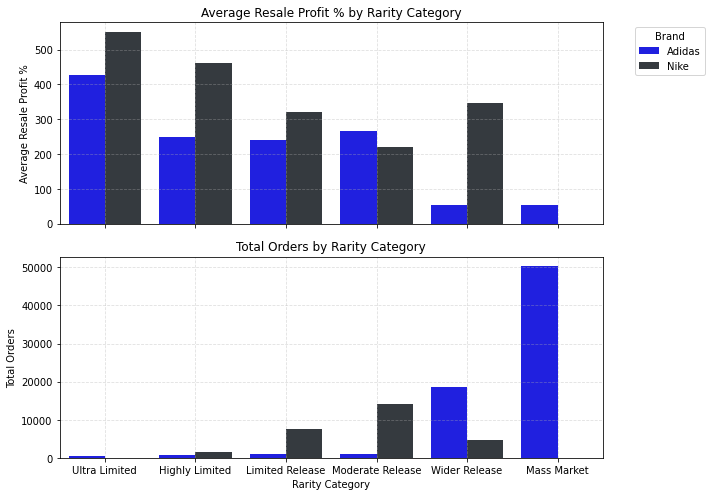

In [142]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True) # 1 column, 2 rows

# create profit barplot
sns.barplot(data=brand_rarity,
                x='rarity_category',
                y='avg_resale_profit_pct',
                estimator='max',
                hue='parent_company',
                palette={'Nike': '#343a40', 'Adidas': 'blue'},
                errorbar=None,
                ax=axes[0])

axes[0].set_title('Average Resale Profit % by Rarity Category')
axes[0].set_xlabel('Rarity Category')
axes[0].set_ylabel('Average Resale Profit %')
axes[0].grid(True, linestyle='--', alpha=0.4)

# Move legend outside
axes[0].legend(title="Brand", bbox_to_anchor=(1.05, 1), loc="upper left")


# create orders barplot
sns.barplot(data=brand_rarity,
                x='rarity_category',
                y='total_orders',
                estimator='max',
                hue='parent_company',
                palette={'Nike': '#343a40', 'Adidas': 'blue'},
                errorbar=None,
                ax=axes[1])

axes[1].set_title('Total Orders by Rarity Category')
axes[1].set_xlabel('Rarity Category')
axes[1].set_ylabel('Total Orders')
axes[1].grid(True, linestyle='--', alpha=0.4)
axes[1].legend_.remove()  # remove individual legend

fig.tight_layout()  # adjust spacing so titles/labels don't overlap
plt.show()

Analysis shows a strong inverse relationship between sneaker availability and profitability. Ultra-limited and highly limited releases command profit margins exceeding 400%, while mass-market releases deliver just ~54%.

**Adidas Yeezy**  
Heavily exposed to Wider Release and Mass Market products, which aligns with Adidas' scaling strategy. This has diluted profitability, despite having more Ultra-Limited Yeezy drops than Nike.

**Nike Off-White**  
Nike has more orders within the more profitable rare categories, with the bulk of sales in Ultra Limited, Highly Limited, and Limited Release categories. Nike has no exposure to the Mass Market category, where profit margins collapse.

This distribution explains the profitability gap between the two strategies: Nike’s scarcity-driven strategy generates structurally higher margins versus Adidas’ broader, volume-led approach.

**Key Insights**

1. **Rarity and profitability are directly linked**
    - Profitability declines as sneakers move from Ultra Limited to Mass Market.
    - This behaviour illustrates a fundamental principle of economics: scarcity fuels demand premiums.

2. **Nike’s scarcity-driven strategy outperforms**
    - Nike has concentrated releases in the more profitable categories (Highly Limited, Limited Release), generating outsized margins.
    - By limiting exposure to mass market, Nike preserves both cultural cachet and resale pricing power.

3. **Adidas’ volume-led model dilutes margins**
    - Adidas has more Ultra Limited drops than Nike, but the bulk of its releases are in Wider Release and Mass Market categories.
    - This strategy captures large order volumes but at significantly lower profitability per sneaker, leading to weaker average margins.

**Investment Implications**

Brands face a strategic tradeoff between scaling releases to capture revenue volume, or preserving scarcity to maximize profitability. Over-scaling can hurt resale value and margins, while undersupplying products risks leaving revenue untapped. 

Investors should assess brand release strategies as a key driver of long-term profitability. Companies concentrated in limited releases signal stronger pricing power, cultural relevance, and brand equity — traits that typically command valuation premiums.

The most attractive long-term investments are brands that can balance scarcity with scale, and that can maintain rarity and hype not just at launch, but across the lifecycle of their products using re-releases, collaborations, and different scarcity tiers to balance volume with value.


## <a id="timing-sales"><a/> Timing of Sales Post-Release


In [143]:
# create bins to label the time after release that an order was made

days_since_release_bins = [-99, 0, 8, 15, 31, 61, 91, 366, 2000]
order_category_labels = ['preorder', '7 days', '14 days', '30 days', '60 days', '90 days', '1 year', '1 year +']

df['order_date_category'] = pd.cut(df['days_since_release'],
                                     bins=days_since_release_bins,
                                     right=False,
                                     labels=order_category_labels
                                     )

In [144]:
sneaker_period_orders = df[(df['release_date'] >= '2017-09-01')] # only filter for sneakers with releases after the intial order date of the data so we can see full distribution

sneaker_period_orders = sneaker_period_orders.groupby(['parent_company', 'sneaker_name', 'order_date_category'], observed=False).agg(
    total_orders_within_period=('order_date', 'count')
    ).reset_index()
sneaker_period_orders.head(20)

,parent_company,sneaker_name,order_date_category,total_orders_within_period
0,Adidas,Adidas-Yeezy-Boost-350-V2-Beluga-2pt0,preorder,437
1,Adidas,Adidas-Yeezy-Boost-350-V2-Beluga-2pt0,7 days,2177
2,Adidas,Adidas-Yeezy-Boost-350-V2-Beluga-2pt0,14 days,1132
3,Adidas,Adidas-Yeezy-Boost-350-V2-Beluga-2pt0,30 days,1465
4,Adidas,Adidas-Yeezy-Boost-350-V2-Beluga-2pt0,60 days,985
5,Adidas,Adidas-Yeezy-Boost-350-V2-Beluga-2pt0,90 days,655
6,Adidas,Adidas-Yeezy-Boost-350-V2-Beluga-2pt0,1 year,2975
7,Adidas,Adidas-Yeezy-Boost-350-V2-Beluga-2pt0,1 year +,569
8,Adidas,Adidas-Yeezy-Boost-350-V2-Blue-Tint,preorder,272
9,Adidas,Adidas-Yeezy-Boost-350-V2-Blue-Tint,7 days,1296


In [145]:
sneaker_period_orders['total_sneaker_orders'] = sneaker_period_orders.groupby(['parent_company', 'sneaker_name'])['total_orders_within_period'].transform('sum')

In [146]:
sneaker_period_pct = sneaker_period_orders.groupby(['parent_company', 'order_date_category'], observed=False).agg(
    total_orders_period = ('total_orders_within_period', 'sum'),
    total_orders = ('total_sneaker_orders', 'sum'),
    )

**Calculate the percentage of total brand orders within each period after release**

In [147]:
sneaker_period_pct['pct_orders_in_period'] = (sneaker_period_pct['total_orders_period'] / sneaker_period_pct['total_orders']) * 100
sneaker_period_pct[['pct_orders_in_period']]

pct_orders_in_period
parent_company order_date_category                      
Adidas         preorder                         4.489927
               7 days                          20.215742
               14 days                         11.674616
               30 days                         14.337177
               60 days                         15.353499
               90 days                          6.719797
               1 year                          18.899555
               1 year +                         8.309686
Nike           preorder                        12.124919
               7 days                          21.680938
               14 days                          7.228179
               30 days                         11.218249
               60 days                         12.657408
               90 days                         12.459524
               1 year                          20.993740
               1 year +                         1.637044

**Adidas Yeezy**
- 20% of orders occurs within one week after release

**Nike Off-White**
- 22% of orders occurs within one week after release

The remainder of sales (approximately 78–93%) occur beyond the first week, spread across 14-day, 30-day, 60-day, 90-day, 1-year, and 1-year-plus periods. This indicates that both brands realize the majority of their revenue well after the initial launch, reflecting sustained consumer interest and market engagement beyond the initial hype period.

**Key Insights**

1. **Early-week vs. long-tail demand**
    - Looking at the order date categories, orders occur the most within the first week after release.
    - However, this accounts for a minority of the total sales after release.
    - The majority of orders are spread across weeks, months, and even years post-release, demonstrating that sneaker resale value persists well beyond the initial drop.

2. **Brand longevity and sustained consumer interest**
    - Nike and Adidas both show significant post-launch sales, with spikes even at the 1-year mark (~19% for Adidas, ~21% for Nike). 
    - This suggests that both brands are supported by ongoing demand rather than purely short-lived hype.
    - The spread of sales indicates that both brands have cultivated a consumer base willing to engage with the resale market continuously.

**Investment Implications**

Investors should prioritize brands that show a consistent, extended demand curve, as these companies are more likely to maintain pricing power and capitalize on long-term consumer loyalty. Adidas and Nike likely reflects a broader industry trend: the resale market is not limited to immediate launch spikes, but driven by sustained demand for culturally significant products. Reliance on short-lived hype cycles carries higher risk, as initial spikes can be volatile and unsustainable.

Evaluating the timing of resale demand provides a forward-looking indicator of brand power. Long-term winners in the sneaker industry will be those that balance immediate hype with sustained engagement, creating both initial excitement and lasting market presence. 

The resale market serves as a valuable proxy for consumer sentiment and brand durability, offering investors insight into which products and companies can sustain profitability over time.


## <a id="linear-regression"><a/> Linear Regression model to see most influential factors


In [148]:
model_data = df[['retail_price', 'shoe_size', 'days_since_release', 'resale_profit_loss_pct', 'resale_profit_loss', 'parent_company', 'pre_order', 'rarity_category']]
model_data = pd.get_dummies(model_data, drop_first=True, dtype=float)

**Investigate the correlations of independent variables**

To check for multicollinearity, investigate the correlation matrix of the features used in the regression model. Look for high correlation coefficients (e.g., above 0.8) between independent variables, which may indicate multicollinearity issues.

In [149]:
# check the correlations between variables
model_data.corr().style.background_gradient(cmap='YlOrRd')

,retail_price,shoe_size,days_since_release,resale_profit_loss_pct,resale_profit_loss,pre_order,parent_company_Nike,rarity_category_Highly Limited,rarity_category_Limited Release,rarity_category_Moderate Release,rarity_category_Wider Release,rarity_category_Mass Market
retail_price,1.000000,-0.052798,0.245391,-0.588700,-0.442450,-0.101473,-0.719996,-0.098077,-0.289259,-0.500555,0.117735,0.454965
shoe_size,-0.052798,1.000000,0.017450,0.082967,0.084637,0.024699,0.073214,0.031279,0.084554,0.027553,-0.058398,-0.029855
days_since_release,0.245391,0.017450,1.000000,-0.134612,-0.106347,-0.202406,-0.332088,0.023263,-0.030172,-0.202809,-0.238177,0.326672
resale_profit_loss_pct,-0.588700,0.082967,-0.134612,1.000000,0.979373,0.176491,0.650173,0.262660,0.382644,0.277173,-0.044962,-0.472895
resale_profit_loss,-0.442450,0.084637,-0.106347,0.979373,1.000000,0.181041,0.592513,0.273817,0.372347,0.221756,-0.023517,-0.451280
pre_order,-0.101473,0.024699,-0.202406,0.176491,0.181041,1.000000,0.175978,-0.025571,-0.009305,-0.006738,0.178693,-0.131004
parent_company_Nike,-0.719996,0.073214,-0.332088,0.650173,0.592513,0.175978,1.000000,0.129419,0.410099,0.617407,-0.096171,-0.624900
rarity_category_Highly Limited,-0.098077,0.031279,0.023263,0.262660,0.273817,-0.025571,0.129419,1.000000,-0.046116,-0.062706,-0.081958,-0.150067
rarity_category_Limited Release,-0.289259,0.084554,-0.030172,0.382644,0.372347,-0.009305,0.410099,-0.046116,1.000000,-0.130187,-0.170159,-0.311563
rarity_category_Moderate Release,-0.500555,0.027553,-0.202809,0.277173,0.221756,-0.006738,0.617407,-0.062706,-0.130187,1.000000,-0.231370,-0.423642


In [150]:
# Create the dataset of x variables
X_with_const = model_data.drop(columns=['resale_profit_loss', 'resale_profit_loss_pct'])

# Add a constant to be used as the intercept
X_with_const.insert(loc=0,column='intercept',value=1)

**Results of the Linear Regression Model**

In [151]:
mod_profit_pct = sm.OLS(model_data['resale_profit_loss_pct'], X_with_const)
res_profit_pct = mod_profit_pct.fit()
print(res_profit_pct.summary())

                              OLS Regression Results                              
Dep. Variable:     resale_profit_loss_pct   R-squared:                       0.547
Model:                                OLS   Adj. R-squared:                  0.547
Method:                     Least Squares   F-statistic:                 1.207e+04
Date:                    Thu, 04 Sep 2025   Prob (F-statistic):               0.00
Time:                            19:02:29   Log-Likelihood:            -6.0367e+05
No. Observations:                   99956   AIC:                         1.207e+06
Df Residuals:                       99945   BIC:                         1.207e+06
Df Model:                              10                                         
Covariance Type:                nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

This regression analysis explored the determinants of resale profitability in the sneaker market.

The results demonstrate that scarcity, brand power, price, time since release and preorder availability all influence resale margins.

**Key Insights**
1. **Brand Effect** – Nike vs. Adidas
    - Nike sneakers yield 144% higher resale premium than Adidas
    - This confirms Nike’s power to generate higher profits than Adidas due to rarity and desirability of its products in the resale market

2. **Rarity** is the Strongest Driver
    - Moving from Ultra Limited to Mass Market releases reduces profitability by 313% 
    - Resale premium declines dramatically as sneakers become more widely available
    - Brands that rely on mass-market releases face diluted premiums, limiting long-term profitability

3. **Retail Price** – Higher Prices Reduce Premiums
    - Each additional \$1 of retail price reduces ROI by 1.5%
    - While high-priced collaborations may generate large revenues, they underperform in resale premium %
    - This suggests consumer's willingness to pay is higher at lower retail prices

4. Resale Premium Builds **Over Time**
    - Resale premium grows 0.04% daily, equivalent to 14% over a year post-release
    - Resale premium is not limited to the launch window but increases as time goes on
    - Demand does not meet supply once sneakers are released, showing scarcity in the resale market increases prices 

5. **Preorder** Signals Market Anticipation
    - Sneakers available for preorder average a 56% higher premium than those that aren’t
    - This suggests that preorder availability increases hype, signaling demand before release
    - Offering preorders can be used as a strategy to increase hype and drive up resale prices

**Investment Implications**

Investors should prioritize companies with scarce product distribution strategies and strong brand power. Signals suggest that luxury pricing reduces the resale premium of products, and the availability of sneakers for preorder can enhance their perceived value. Companies with sneakers that retain long-term desirability should be weighted more favorably in investment decisions.